In [71]:
import tensorflow as tf
from tensorflow.keras import layers
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.optimizers.legacy import Adam

# Prepare the Dataset
### 15747 images (64,64,3)



In [72]:
dataset_dir = "./cats"

dataset = []
for each in os.listdir(dataset_dir):
    image = cv2.imread(os.path.join(dataset_dir, each))
    if type(image) != type(None):
        dataset.append(image)

dataset = np.array(dataset)
print(dataset.shape)

(15747, 64, 64, 3)


In [73]:
dataset.min(), dataset.max()

(0, 255)

In [74]:
dataset = (dataset - 127.5)/127.5    # Normalize the images to [-1, 1]
dataset.min(), dataset.max()

(-1.0, 1.0)

In [75]:
# Batch and shuffle the data
BATCH_SIZE = 256
BUFFER_SIZE = 15747

train_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_dataset)

<BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float64, name=None)>


# Create the Model


## Generator 


In [76]:
def generator_model(noise_dim):
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(4*4*1024, input_shape=(noise_dim,)))
    model.add(layers.Reshape((4, 4, 1024)))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(filters=512, kernel_size=(5,5), strides=(2,2), padding='same',
            kernel_initializer=tf.initializers.truncated_normal(stddev=0.02)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(filters=256, kernel_size=(5,5), strides=(2,2), padding='same',
             kernel_initializer=tf.initializers.truncated_normal(stddev=0.02)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(filters=128, kernel_size=(5,5), strides=(2,2), padding='same',
             kernel_initializer=tf.initializers.truncated_normal(stddev=0.02)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    

    model.add(layers.Conv2DTranspose(filters=64, kernel_size=(5,5), strides=(2,2), padding='same',
             kernel_initializer=tf.initializers.truncated_normal(stddev=0.02)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(filters=3, kernel_size=(5,5), strides=(1,1), padding='same',
             kernel_initializer=tf.initializers.truncated_normal(stddev=0.02),
             activation='tanh'))
    # output (64,64,3)

    return model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[[[[-1.65877427e-04 -1.73718130e-04  1.87302299e-04]
   [-1.03455421e-03  1.12121610e-03  6.95876428e-04]
   [-1.41342593e-04  3.70484369e-04 -1.11234636e-04]
   ...
   [ 3.19103105e-03  1.20744179e-03  1.70672208e-03]
   [ 1.25637569e-03 -3.58620688e-04  1.25150010e-03]
   [-3.52327945e-04  1.73178909e-03 -1.83317883e-04]]

  [[ 7.81163806e-04  5.99441933e-04  3.97345459e-04]
   [-3.84166669e-05 -8.07410106e-05  2.25910146e-04]
   [ 3.54581454e-04  3.79597041e-04  4.16760711e-04]
   ...
   [ 1.12448691e-03  3.12546501e-03  1.45455904e-03]
   [-1.53538527e-03  1.33354205e-03 -1.68726943e-03]
   [ 2.85186456e-04 -3.41889885e-04  1.19114923e-03]]

  [[-3.37177946e-04  4.79170412e-04  5.01619361e-04]
   [ 1.97532238e-03  1.26999058e-03 -4.70501924e-04]
   [-4.89802565e-04 -1.81350231e-04  4.04699131e-05]
   ...
   [-5.84108871e-04  3.60347959e-03  2.65766052e-04]
   [ 2.57850671e-03  2.26751249e-03  5.71936951e-04]
   [-2.49507662e-04  6.02597254e-04  2.87286130e-05]]

  ...

 

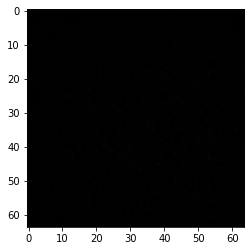

In [77]:
# Test
noise_dim = 100
generator = generator_model(noise_dim)
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)
print(generated_image)
plt.imshow(generated_image[0, :, :, :])

## Discriminator

In [87]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(filters=64, kernel_size=(5,5), strides=(2,2), padding='same', input_shape=(64, 64, 3)))
    model.add(layers.BatchNormalization(epsilon = 1e-5))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(filters=128, kernel_size=(5,5), strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization(epsilon = 1e-5))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(filters=256, kernel_size=(5,5), strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization(epsilon = 1e-5))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(filters=512, kernel_size=(5,5), strides=(1,1), padding='same'))
    model.add(layers.BatchNormalization(epsilon = 1e-5))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(filters=1024, kernel_size=(5,5), strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization(epsilon = 1e-5))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid')) # relu or sigmoid ?!
    
    return model

In [97]:
# Test

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.49993718]], shape=(1, 1), dtype=float32)


## Model Loss

In [99]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [100]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [101]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [102]:
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

### Save Checkpoints

In [103]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training Loop

In [104]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [105]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    print(noise)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [106]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
            
        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                             epoch + 1,
                             seed)
        
        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
          checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [107]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8, 8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :] * 0.5 + 0.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [108]:
train(train_dataset, EPOCHS)

Tensor("random_normal:0", shape=(256, 100), dtype=float32)
Tensor("random_normal:0", shape=(256, 100), dtype=float32)


KeyboardInterrupt: 